# TranscriptHomies 🧬🤝
#### <span style="color: blue;">_Explore how genes work together. This tool maps gene–gene expression correlations within your dataset, helping you discover coordinated expression patterns and visualize network structures that define biological systems._</span>
#### **Team Members:** Grace Beggs, Caroline Harrer, HeaJin Hong, Tess Kelly, Zilin Xianyu
#### **TAs:** Riley Kellermeyer, Bekah Kim

## Data Input and Organization

## Analysis 

### Part 1: Correlation Analysis

#### loading input

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr, spearmanr
from scipy.stats import false_discovery_control


# input 1: gene expression matrix (genes x samples)
df = pd.read_csv("final_input_filtered.csv", index_col=0)
print(df.head())

                 1622003800C  1621001800C  1622003500C  1621003700C  \
gene_id                                                               
NONHSAG104656.1            8           12           15           42   
ENSG00000198692           14            5            5           14   
NONHSAG104654.1            8            3            0            4   
NONHSAG115270.1           18           14            5           13   
NONHSAG104622.1            9            9           82           12   

                 1621002900C  1621002200C  162200380CP  162100180CP  \
gene_id                                                               
NONHSAG104656.1            7           14           18            6   
ENSG00000198692           12           21           15            6   
NONHSAG104654.1            2            9            6           10   
NONHSAG115270.1           10           14            7           16   
NONHSAG104622.1           63           11           31            8   

    

#### normalize raw counts

In [3]:
# Split data: all but last two columns for normalization
df_main = df.iloc[:, :-2]     # everything except last 2 columns
df_extra = df.iloc[:, -2:]    # last 2 columns kept as-is

# Convert to float and normalize
df_main = df_main.astype(float)
df_z = df_main.apply(lambda x: zscore(x), axis=1, result_type='broadcast')

# Rejoin
df_final = pd.concat([df_z, df_extra], axis=1)

# Replace rowname with second-to-last column
df_final.index = df.iloc[:, -2]
# get rid of last two columns
df_final = df_final.iloc[:, :-2]
print(df_final.head())

        1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                    
-         -0.876549    -0.504209    -0.224955     2.288335    -0.969633   
EIF1AY     0.500639    -1.430397    -1.430397     0.500639     0.071520   
-          0.475744    -1.026605    -1.928015    -0.726135    -1.327075   
-          0.979816     0.221249    -1.485528     0.031607    -0.537319   
-         -0.720726    -0.720726     2.516997    -0.587669     1.674302   

        1621002200C  162200380CP  162100180CP  162200350CP  162100370CP  \
symbol                                                                    
-         -0.318040     0.054299    -1.062718     1.822911     0.054299   
EIF1AY     2.002556     0.715199    -1.215838     0.286079    -0.357599   
-          0.776214    -0.125196     1.076684    -0.125196     0.776214   
-          0.221249    -1.106244     0.600533    -1.485528     2.117667   
-         -0.632021     

#### loading pathway of interest

In [4]:
# input 2: pathway
pathway = pd.read_csv("lin/GO_pathways_genes.csv")

poi = "GOBP_CYTOKINESIS"
genes_in_pathway = pathway.loc[pathway['Pathway'] == poi, 'Gene'].tolist()
print(f"Genes in pathway {poi}: {genes_in_pathway}")

# filter df_final to include only genes in the pathway
df_poi = df_final.loc[df_final.index.isin(genes_in_pathway)]
print("Filtered expression DataFrame:\n", df_poi.head(), "\n")


Genes in pathway GOBP_CYTOKINESIS: ['ACTR2', 'ACTR3', 'AHCTF1', 'ALKBH4', 'ANK3', 'ANKRD53', 'ANLN', 'ANXA11', 'APC', 'ARF1', 'ARF6', 'ARL3', 'ATXN10', 'AURKA', 'AURKB', 'AURKC', 'BBS4', 'BCL2L1', 'BECN1', 'BIN3', 'BIRC5', 'BIRC6', 'BRCA2', 'CALM1', 'CALM2', 'CALM3', 'CCDC66', 'CCP110', 'CDC14A', 'CDC14B', 'CDC14C', 'CDC25B', 'CDC42', 'CDC6', 'CDCA8', 'CECR2', 'CENPA', 'CENPV', 'CEP55', 'CETN2', 'CFL1', 'CHMP1A', 'CHMP1B', 'CHMP2A', 'CHMP2B', 'CHMP3', 'CHMP4A', 'CHMP4B', 'CHMP4BP1', 'CHMP4C', 'CHMP5', 'CHMP6', 'CHMP7', 'CIT', 'CKAP2', 'CNTROB', 'CSPP1', 'CUL3', 'CUL7', 'CXCR5', 'DCDC1', 'DCTN3', 'DRD2', 'DRD3', 'E2F7', 'E2F8', 'ECT2', 'EFHC1', 'ENTR1', 'ESPL1', 'EXOC1', 'EXOC2', 'EXOC3', 'EXOC4', 'EXOC5', 'EXOC6', 'EXOC6B', 'EXOC7', 'EXOC8', 'FMN2', 'FSD1', 'GIPC1', 'GIT1', 'INCENP', 'IQGAP1', 'IQGAP2', 'IQGAP3', 'IST1', 'JTB', 'KIF13A', 'KIF14', 'KIF20A', 'KIF20B', 'KIF23', 'KIF3B', 'KIF4A', 'KIF4B', 'KLHDC8B', 'KLHL13', 'KLHL21', 'KLHL9', 'LUZP1', 'LZTS2', 'MAP10', 'MAP9', 'MITD1', '

#### spliting dataset into "Disease" and "Normal" subgroups

In [5]:
# Split columns by substring
nm_cols = [c for c in df_poi.columns if "0CP" in c]
ds_cols = [c for c in df_poi.columns if "P" not in c]

# Create two separate DataFrames
df_nm = df_poi[nm_cols]
df_ds = df_poi[ds_cols]

print("NM subset:\n", df_nm.head(), "\n")
print("DS subset:\n", df_ds.head(), "\n")

NM subset:
          162200380CP  162100180CP  162200350CP  162100370CP  162100290CP  \
symbol                                                                     
CETN2      -0.333385     0.206491    -1.368841     0.115128    -0.732063   
SEPTIN6    -0.774774    -0.097936    -0.791695    -0.410205    -0.797848   
KLHL13      2.237504     1.482906    -0.269830     0.926422    -0.141119   
KIF4A      -1.126768    -0.557018    -1.034462    -0.907144    -1.120402   
ATXN10     -0.139306     2.057496    -0.789886     1.208532    -0.188902   

         162100220CP  
symbol                
CETN2      -0.164501  
SEPTIN6    -0.699399  
KLHL13      0.292964  
KIF4A      -0.716166  
ATXN10      0.814684   

DS subset:
          1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0

#### processing "Disease" subgroup

In [6]:
expression_df = df_ds # using only NM samples for correlation
name = "DS"
expression_df = expression_df.loc[expression_df.var(axis=1) > 1e-6] 
print(expression_df)

         1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0.760930     2.057177   
KLHL13     -0.658485    -0.406111    -0.854075    -0.556274    -1.101401   
KIF4A       1.008998     0.464712     1.970252     0.773459     0.989901   
ATXN10     -0.083875    -0.113049     0.797179    -1.285844    -0.962012   
...              ...          ...          ...          ...          ...   
BECN1      -1.636028    -0.412575    -0.954973     0.545796    -1.831781   
ACTR2       1.391849     1.023247     0.203196     1.341849     1.289815   
SEPTIN9    -0.642075     0.331555    -0.168986     2.938003    -0.609633   
BIRC5       0.338088    -0.099608    -0.058114     0.667364     3.008437   
CHMP6      -1.145599     0.499249    -0.182761     0.218422    -1.814236   

         16

#### running gene-gene correlation calculation

In [7]:
# gene-gene correlation matrix
genes = expression_df.index
#print(genes)
n_genes = len(genes)

pearson_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
pearson_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

spearman_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
spearman_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

# pairwise correlations and p-values
for i, g1 in enumerate(genes):
    for j, g2 in enumerate(genes):
        if j >= i:
            r, p = pearsonr(expression_df.loc[g1], expression_df.loc[g2])
            pearson_corr.loc[g1, g2] = pearson_corr.loc[g2, g1] = r
            pearson_pval.loc[g1, g2] = pearson_pval.loc[g2, g1] = p

            r_s, p_s = spearmanr(expression_df.loc[g1], expression_df.loc[g2])
            spearman_corr.loc[g1, g2] = spearman_corr.loc[g2, g1] = r_s
            spearman_pval.loc[g1, g2] = spearman_pval.loc[g2, g1] = p_s


# FDR (Benjamini-Hochberg) 
# explain why FDR correction is needed
pearson_fdr = pd.DataFrame(
    false_discovery_control(pearson_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

spearman_fdr = pd.DataFrame(
    false_discovery_control(spearman_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

print("Pearson Correlation Matrix:")
print(pearson_corr)
print("Pearson FDR Matrix:")
print(pearson_fdr)
print("Spearman Correlation Matrix:")
print(spearman_corr)
print("Spearman FDR Matrix:")
print(spearman_fdr) 


Pearson Correlation Matrix:
symbol      CETN2   SEPTIN6    KLHL13     KIF4A    ATXN10   SEPTIN5     CECR2  \
symbol                                                                          
CETN2    1.000000  0.189916  0.356430  0.422064  0.277020  0.500771  0.430316   
SEPTIN6  0.189916  1.000000 -0.225565  0.161438  0.241762  0.669487 -0.568893   
KLHL13   0.356430 -0.225565  1.000000 -0.226313  0.194034  0.420591  0.428719   
KIF4A    0.422064  0.161438 -0.226313  1.000000  0.739218  0.408510 -0.158160   
ATXN10   0.277020  0.241762  0.194034  0.739218  1.000000  0.724720 -0.461109   
...           ...       ...       ...       ...       ...       ...       ...   
BECN1   -0.202966 -0.935441  0.391484 -0.466774 -0.447107 -0.654450  0.654689   
ACTR2    0.519959  0.526433  0.353661 -0.138329 -0.210237  0.475127  0.360540   
SEPTIN9  0.334631 -0.573671  0.551301 -0.086305 -0.305725 -0.191849  0.948233   
BIRC5   -0.096748  0.562024 -0.560315  0.067378 -0.358177 -0.017880 -0.072252   


#### choose linear vs non-linear relationship

In [8]:
# Define FDR significance threshold
fdr_threshold = 0.05

# Count significant gene–gene pairs (excluding self-pairs)
pearson_sig = np.sum((pearson_fdr < fdr_threshold).values) - len(genes)
spearman_sig = np.sum((spearman_fdr < fdr_threshold).values) - len(genes)

print(f"Significant Pearson pairs (FDR<{fdr_threshold}): {pearson_sig}")
print(f"Significant Spearman pairs (FDR<{fdr_threshold}): {spearman_sig}")

# Compare counts
# highlight pearson vs spearman choosen method
if pearson_sig > spearman_sig:
    chosen_method = "pearson"
elif spearman_sig > pearson_sig:
    chosen_method = "spearman"
else:
    # Tie → compare average |r²|
    pearson_r2 = np.nanmean(np.square(pearson_corr.values))
    spearman_r2 = np.nanmean(np.square(spearman_corr.values))
    chosen_method = "pearson" if pearson_r2 > spearman_r2 else "spearman"

print(f"Chosen method: {chosen_method.upper()}")

if chosen_method == "pearson":
    pearson_corr.to_csv(f"pearson_gene_correlation_r2_{name}.csv")
    pearson_fdr.to_csv(f"pearson_gene_correlation_fdr_{name}.csv")
else:
    spearman_corr.to_csv(f"spearman_gene_correlation_r2_{name}.csv")
    spearman_fdr.to_csv(f"spearman_gene_correlation_fdr_{name}.csv")


Significant Pearson pairs (FDR<0.05): 46
Significant Spearman pairs (FDR<0.05): 144
Chosen method: SPEARMAN


#### processing "Normal" subgroup

In [18]:
expression_df = df_nm # using only NM samples for correlation
name = "NM"
expression_df = expression_df.loc[expression_df.var(axis=1) > 1e-6] 
print(expression_df)

# gene-gene correlation matrix
genes = expression_df.index
#print(genes)
n_genes = len(genes)

pearson_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
pearson_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

spearman_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
spearman_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

# pairwise correlations and p-values
for i, g1 in enumerate(genes):
    for j, g2 in enumerate(genes):
        if j >= i:
            r, p = pearsonr(expression_df.loc[g1], expression_df.loc[g2])
            pearson_corr.loc[g1, g2] = pearson_corr.loc[g2, g1] = r
            pearson_pval.loc[g1, g2] = pearson_pval.loc[g2, g1] = p

            r_s, p_s = spearmanr(expression_df.loc[g1], expression_df.loc[g2])
            spearman_corr.loc[g1, g2] = spearman_corr.loc[g2, g1] = r_s
            spearman_pval.loc[g1, g2] = spearman_pval.loc[g2, g1] = p_s


# FDR (Benjamini-Hochberg) 
# explain why FDR correction is needed
pearson_fdr = pd.DataFrame(
    false_discovery_control(pearson_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

spearman_fdr = pd.DataFrame(
    false_discovery_control(spearman_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

# Define FDR significance threshold
fdr_threshold = 0.05

# Count significant gene–gene pairs (excluding self-pairs)
pearson_sig = np.sum((pearson_fdr < fdr_threshold).values) - len(genes)
spearman_sig = np.sum((spearman_fdr < fdr_threshold).values) - len(genes)

# Compare counts
# highlight pearson vs spearman choosen method
if pearson_sig > spearman_sig:
    chosen_method = "pearson"
elif spearman_sig > pearson_sig:
    chosen_method = "spearman"
else:
    # Tie → compare average |r²|
    pearson_r2 = np.nanmean(np.square(pearson_corr.values))
    spearman_r2 = np.nanmean(np.square(spearman_corr.values))
    chosen_method = "pearson" if pearson_r2 > spearman_r2 else "spearman"

print(f"Chosen method: {chosen_method.upper()}")

if chosen_method == "pearson":
    pearson_corr.to_csv(f"pearson_gene_correlation_r2_{name}.csv")
    pearson_fdr.to_csv(f"pearson_gene_correlation_fdr_{name}.csv")
else:
    spearman_corr.to_csv(f"spearman_gene_correlation_r2_{name}.csv")
    spearman_fdr.to_csv(f"spearman_gene_correlation_fdr_{name}.csv")

         162200380CP  162100180CP  162200350CP  162100370CP  162100290CP  \
symbol                                                                     
CETN2      -0.333385     0.206491    -1.368841     0.115128    -0.732063   
SEPTIN6    -0.774774    -0.097936    -0.791695    -0.410205    -0.797848   
KLHL13      2.237504     1.482906    -0.269830     0.926422    -0.141119   
KIF4A      -1.126768    -0.557018    -1.034462    -0.907144    -1.120402   
ATXN10     -0.139306     2.057496    -0.789886     1.208532    -0.188902   
...              ...          ...          ...          ...          ...   
BECN1       0.810877     0.076806     0.301105     0.855737     0.309262   
ACTR2      -1.306675    -0.768598    -1.442721    -0.523833    -0.606681   
SEPTIN9    -0.275583     0.709456     0.191446    -0.147239    -0.794305   
BIRC5      -0.679188    -0.501164    -0.629662    -0.578799    -0.748791   
CHMP6       0.927177     0.579486     2.224334     0.245167    -0.610689   

         16

#### PCA

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

data = df_poi.loc[df_poi.var(axis=1) > 1e-6] 
print("Data for PCA:")
print(data)

Data for PCA:
         1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0.760930     2.057177   
KLHL13     -0.658485    -0.406111    -0.854075    -0.556274    -1.101401   
KIF4A       1.008998     0.464712     1.970252     0.773459     0.989901   
ATXN10     -0.083875    -0.113049     0.797179    -1.285844    -0.962012   
...              ...          ...          ...          ...          ...   
BECN1      -1.636028    -0.412575    -0.954973     0.545796    -1.831781   
ACTR2       1.391849     1.023247     0.203196     1.341849     1.289815   
SEPTIN9    -0.642075     0.331555    -0.168986     2.938003    -0.609633   
BIRC5       0.338088    -0.099608    -0.058114     0.667364     3.008437   
CHMP6      -1.145599     0.499249    -0.182761     0.218422    -1.814236  

In [10]:
# expression_df: rows = genes, columns = samples
data_T = data.T  # now rows = samples, columns = genes
print("Transposed Data for PCA:")
print(data_T)

Transposed Data for PCA:
symbol          CETN2   SEPTIN6    KLHL13     KIF4A    ATXN10   SEPTIN5  \
1622003800C  2.288476  1.995646 -0.658485  1.008998 -0.083875  1.241662   
1621001800C -0.560410  0.661968 -0.406111  0.464712 -0.113049  0.752668   
1622003500C  0.635624  0.095885 -0.854075  1.970252  0.797179  0.196557   
1621003700C  1.430211 -0.760930 -0.556274  0.773459 -1.285844 -1.001959   
1621002900C -0.408137  2.057177 -1.101401  0.989901 -0.962012 -0.254085   
1621002200C -1.108593 -0.477888 -0.952501  0.254637 -1.315018 -2.085418   
162200380CP -0.333385 -0.774774  2.237504 -1.126768 -0.139306 -1.021136   
162100180CP  0.206491 -0.097936  1.482906 -0.557018  2.057496  1.203310   
162200350CP -1.368841 -0.791695 -0.269830 -1.034462 -0.789886  1.289603   
162100370CP  0.115128 -0.410205  0.926422 -0.907144  1.208532 -0.148616   
162100290CP -0.732063 -0.797848 -0.141119 -1.120402 -0.188902 -0.436260   
162100220CP -0.164501 -0.699399  0.292964 -0.716166  0.814684  0.263674   


In [11]:
# Define a function to assign group based on column names
def assign_group(sample_name):
    if 'P' not in sample_name:
        return 'Disease'
    elif 'CP' in sample_name:
        return 'Normal'
    else:
        return 'Unknown'
# Apply to all sample names (index after transpose)
groups = [assign_group(s) for s in data_T.index]
print(groups)

['Disease', 'Disease', 'Disease', 'Disease', 'Disease', 'Disease', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal']


In [12]:
# Initialize PCA (2 components for a 2D plot)
pca = PCA(n_components=2)

# Fit PCA to the data
pca_result = pca.fit_transform(data_T)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=data_T.index)

# annotation
pca_df['Group'] = groups
print("PCA Result DataFrame:")
print(pca_df)

PCA Result DataFrame:
                   PC1        PC2    Group
1622003800C  11.100280  -6.657270  Disease
1621001800C   1.431448  -2.719960  Disease
1622003500C  11.908748   2.277931  Disease
1621003700C   9.962801  13.814682  Disease
1621002900C   9.538745  -6.537030  Disease
1621002200C  -0.238424  -4.301544  Disease
162200380CP  -6.266468   1.690934   Normal
162100180CP  -4.606138   0.720776   Normal
162200350CP  -7.383634   1.063477   Normal
162100370CP  -8.128131   2.469863   Normal
162100290CP  -9.079156  -1.420467   Normal
162100220CP  -8.240070  -0.401393   Normal


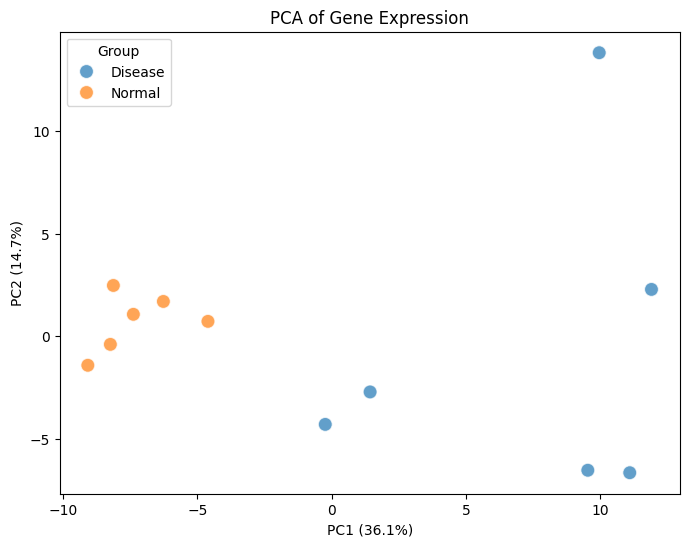

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pca_df, s=100, alpha=0.7)  # added alpha
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Gene Expression")
plt.legend(title='Group')
plt.show()

## Output and Visualization